# Simple Walkthrough

> For a more detailed walkthrough, please see individual tutorials.

## Initiate Dask dashboard (optional)

Most functions in py_clone_detector are parallised using [Dask](https://dask.org/). When using the Dask distributed scheduler, we can access to an interactive dashboard that details the status, progress and history of our computations. This is especially useful when working on a remote cluster, but also convenient when working on just our local machine (e.g. MacBook).

**N.B** Initiating a Dask scheduler is optional when working on your local machine. If you don't launch one, all computations should still run, you just won't have access to the fancy dashboard!

Launch the scheduler as follows on your local machine and click on the dashboard link:

In [ ]:
from dask.distributed import Client
c = Client()
c

<img src="docs/images/client_setup.png">

If working on a remote cluster e.g. a SLURM HPC, please the relevant [Dask guides](https://jobqueue.dask.org/en/latest/index.html).

## Import and instantiate CloneCounter subclass:

The LazyCloneCounter subclass uses Dask to lazy load image series that maybe too large to fit in RAM. If your data is small enough to fit into RAM, you can speed things up by using the PersistentCloneCounter subclass.

In [ ]:
from py_clone_detective.clone_counters import LazyCloneCounter

We intialise a LazyCloneCounter with four required arguments:

1) **exp_name** : str -> name of the experiment
2) **img_name_regex** : str -> regular expression used to extract unique identifies from image filenames
3) **pixel_size** : str -> pixel size in $\mu m^{2}$
4) **tot_seg_ch** : str -> image channel used to define the total number of cells e.g. DAPI channel.

In [ ]:
exp = LazyCloneCounter(
    exp_name="Marcm2a_E7F1",
    img_name_regex=r"a\dg\d\dp\d",
    pixel_size=0.275,
    tot_seg_ch="C0",
)

## Load images and segmentations

We add images to the LazyCloneCounter instance by passing filename "glob" for each of the image channel.

In this experiment, there are four image channels:

- C0 : DAPI (nuclear marker)
- C1 : GFP (clone marker)
- C2 : PDM1 staining (EnteroCyte marker)
- C3 : Prospero staining (EndoEndocrine marker)

In [ ]:
exp.add_images(
    C0="data/MARCM_experiment/images/C0/*.tif",
    C1="data/MARCM_experiment/images/C1/*.tif",
    C2="data/MARCM_experiment/images/C2/*.tif",
    C3="data/MARCM_experiment/images/C3/*.tif",
)

Image data is stored in an Xarray dataset:

In [ ]:
exp.image_data

,Array,Chunk
Bytes,335.38 MiB,1.25 MiB
Shape,"(4, 67, 810, 810)","(1, 1, 810, 810)"
Count,1072 Tasks,268 Chunks
Type,uint16,numpy.ndarray


We can access specific images using the ".sel" notation. In the example below, we index an image, load it into RAM (the ".compute()" call), and display it using matplotlib.

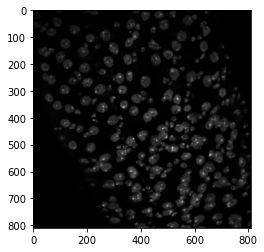

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(
    exp.image_data["images"].sel(img_channels="C0", img_name="a1g01p1").compute(),
    cmap="gray",
)

We can **segmentations** in the same fashion...

**N.B.** 
At a minimum, py_clone_detector requires a segmentation for the "tot_seg_ch" (see above for definition). If you do not have a suitable segmentation, check out the example tutorial using StarDist.

In [ ]:
exp.add_segmentations(C0="data/MARCM_experiment/segmentations/C0_stardist_segs/*.tif")

Segmentations have now been added to the Xarray dataset:

In [ ]:
exp.image_data

,Array,Chunk
Bytes,335.38 MiB,1.25 MiB
Shape,"(4, 67, 810, 810)","(1, 1, 810, 810)"
Count,1072 Tasks,268 Chunks
Type,uint16,numpy.ndarray
,Array,Chunk
Bytes,83.84 MiB,1.25 MiB
Shape,"(1, 67, 810, 810)","(1, 1, 810, 810)"
Count,335 Tasks,67 Chunks
Type,uint16,numpy.ndarray


## Measure cell properties

We can now measure properties of each segmented cell within our images by calling:

In [ ]:
exp.make_measurements()